In [1]:
# Import packages 
import numpy as np
import xarray as xr
from scipy.stats import linregress as _linregress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gp
import regionmask
from matplotlib.ticker import MultipleLocator
from cartopy.util import add_cyclic_point
import glob as glob
import pandas as pd
import xesmf as xe
import matplotlib.colors as mcolors
import cartopy.mpl.ticker as cticker

In [2]:
def area_weighted_ave(ds):
    if 'lat' not in ds.dims:
        ds = ds.rename({'latitude':'lat','longitude':'lon'})
    coslat = np.cos(np.deg2rad(ds.lat))
    ds,coslat = xr.broadcast(ds,coslat)
    ds = ds * coslat
    #return ds.mean(('lat','lon'),skipna=True)
    return ds.sum(('lat','lon'),skipna=True)/((ds/ds)*coslat).sum(('lat','lon'),skipna=True)


def linregress(da_y, da_x, dim=None):
    '''xarray-wrapped function of scipy.stats.linregress.
    Note the order of the input arguments x, y is reversed to the original scipy function.'''
    if dim is None:
        dim = [d for d in da_y.dims if d in da_x.dims][0]

    slope, intercept, r, p, stderr = xr.apply_ufunc(_linregress, da_x, da_y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,
        dask='allowed')
    predicted = da_x * slope + intercept

    slope.attrs['long_name'] = 'slope of the linear regression'
    intercept.attrs['long_name'] = 'intercept of the linear regression'
    r.attrs['long_name'] = 'correlation coefficient'
    p.attrs['long_name'] = 'p-value'
    stderr.attrs['long_name'] = 'standard error of the estimated gradient'
    predicted.attrs['long_name'] = 'predicted values by the linear regression model'

    return xr.Dataset(dict(slope=slope, intercept=intercept,
        r=r, p=p, stderr=stderr, predicted=predicted))


def draw_boxes(lon_min,lon_max,lat_min,lat_max):
    
    box_lon = [lon_min, lon_max, lon_max, lon_min, lon_min]
    box_lat = [lat_min, lat_min, lat_max, lat_max, lat_min]

    # Plot the box using plt.plot (on the same projection)
    ax.plot(box_lon, box_lat, color='k', linestyle='-', linewidth=2, zorder=20, transform=ccrs.PlateCarree())


def convert_longitude(ds):
    """
    Convert longitude from [0, 360] to [-180, 180].
    
    Parameters:
    - lon: array-like, input longitudes in the range [0, 360]
    
    Returns:
    - Converted longitudes in the range [-180, 180]
    """
    ds_new = ds.copy()
    lon = ds['longitude']  # Convert input to a NumPy array if it's not already
    converted_lon = (lon + 180) % 360 - 180  # Apply conversion
    ds_new.coords['longitude'] = converted_lon
    return ds_new.sortby('longitude')


def maskgen(shpfile, dat4mask, regionname):

    maskcoords = xr.Dataset({'latitude' : (['latitude'],dat4mask['latitude'].values)}, {'longitude' : (['longitude'],dat4mask['longitude'].values)})

    mask = np.zeros([maskcoords.latitude.size, maskcoords.longitude.size])

    shpcontents = gp.read_file(shpfile)

    for i in range(0,len(regionname),1):
        #print('masking '+regionname[i])
        try:
            region = shpcontents[shpcontents.NAME_1 == regionname[i]]

        except:
            region = shpcontents[shpcontents.NAME_0 == regionname[i]]
        maskt = regionmask.mask_geopandas(region, maskcoords['longitude'], maskcoords['latitude'])
        maskt = np.where(np.isnan(maskt), 0, 1)
        mask[:,:] = mask[:,:] + maskt[:,:]

    mask = np.where(mask == 0, np.nan, 1)
    mask = xr.DataArray(mask, coords = maskcoords.coords)

    return mask


def get_ee(ds):
    ds_con = convert_longitude(ds)
    return area_weighted_ave(ds_con.sel(longitude=slice(-10,15),latitude=slice(36, 60)))

In [3]:
class XESMFRegridder:
    def __init__(self, ds_out, method='bilinear', periodic=False, **kwargs):
        #self.regridder = xe.Regridder(ds_in, ds_out, method, periodic, **kwargs)
        self.ds_out = ds_out
        self.method = method
        print('Starting')

    def regrid(self,ds):
        #if 'lat_bnds' not in list(ds.coords.keys()):
        #    ds = ds.expand_dims({'bnds':[1,2]})
        
        #    ds = self.add_lat_lon_bounds(ds)
        #if len(ds['lat_bnds'].dims) > 2:
        #    ds = self.add_lat_lon_bounds(ds) 
        #print(ds)
        regridder = xe.Regridder(ds, self.ds_out, self.method)
        dr_out = regridder(ds, keep_attrs=True)

        return dr_out

    def add_lat_lon_bounds(self, ds, lat_name='lat', lon_name='lon'):
        """
        Function to add latitude and longitude bounds to a dataset
        for conservative regridding with xESMF.

        Parameters:
        - ds: xarray Dataset or DataArray containing latitude and longitude coordinates
        - lat_name: Name of the latitude coordinate in the dataset (default is 'lat')
        - lon_name: Name of the longitude coordinate in the dataset (default is 'lon')

        Returns:
        - ds: Dataset with added 'lat_bnds' and 'lon_bnds' variables
        """

        # Get latitude and longitude coordinates
        lat = ds[lat_name]
        lon = ds[lon_name]

        # Calculate latitude bounds
        lat_diff = np.diff(lat) / 2.0
        lat_bnds = np.empty((lat.size, 2), dtype=np.float64)
        lat_bnds[:, 0] = lat - np.concatenate(([lat_diff[0]], lat_diff))
        lat_bnds[:, 1] = lat + np.concatenate((lat_diff, [lat_diff[-1]]))

        # Calculate longitude bounds
        lon_diff = np.diff(lon) / 2.0
        lon_bnds = np.empty((lon.size, 2), dtype=np.float64)
        lon_bnds[:, 0] = lon - np.concatenate(([lon_diff[0]], lon_diff))
        lon_bnds[:, 1] = lon + np.concatenate((lon_diff, [lon_diff[-1]]))

        # Add latitude and longitude bounds to dataset
        ds.coords['lat_bnds'] = (('lat', 'bnds'), lat_bnds)
        ds.coords['lon_bnds'] = (('lon', 'bnds'), lon_bnds)

        return ds

In [4]:
era5_regrid = xr.open_dataset('/scratch/midway3/krucker01/ERA5/e5.oper.an.sfc.128_167_2t.ll025sc.1979-2025.nc')
era5_regrid = era5_regrid.rename({'lat':'latitude','lon':'longitude'})

In [5]:
amip_tasmax_regress = xr.open_dataset('/scratch/midway3/itbaxter/MAPP_stracks/MAPP_stracks/ECA/scripts/v2.6/data/amip_tasmax_trend_1979-2014.nc')
amip_tasmax = (xr.open_dataset('/scratch/midway3/itbaxter/MAPP_stracks/MAPP_stracks/ECA/scripts/v2.6/data/amip_tasmax_trend_1979-2014.nc')['polyfit_coefficients'])*10
amip_tasmax = amip_tasmax.rename({'lat':'latitude','lon':'longitude'})
amip_tasmax['latitude'] = era5_regrid['latitude']
amip_tasmax['longitude'] = era5_regrid['longitude']

In [6]:
def preprocess(ds):
    ds_y = ds['TMP2m'].sel(year=slice(1981,2014))
    return linregress(ds_y.compute(),ds_y.year)

ace2_tasmax = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_annual_TXx_1980_2022.nc').compute()
ace2_tasmax['latitude'] = era5_regrid['latitude']
ace2_tasmax['longitude'] = era5_regrid['longitude']

ace2_tasmax_regress = preprocess(xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_annual_TXx_1980_2022.nc')).compute()
ace2_tasmax_regress['latitude'] = era5_regrid['latitude']
ace2_tasmax_regress['longitude'] = era5_regrid['longitude']
ace2_tasmax_trend = (ace2_tasmax_regress.slope)*10


In [7]:
# NGCM
ngcm_1000 = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ngcm/ngcm_TXx1000.nc').compute()

In [16]:
cesm = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/AMIP/cesm_TXx_t2m.nc').compute()
cesm_tasmax = cesm.rename({'lat':'latitude','lon':'longitude'}).TSMX

# Course mask
land_sea_mask = xr.open_dataset('/scratch/midway2/krucker01/shp/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc')

#Regrid mask
lat01 = land_sea_mask['latitude']
lon01 = land_sea_mask['longitude']

lat28 = cesm_tasmax['latitude']
lon28 = cesm_tasmax['longitude']

mask_era5_cesm = land_sea_mask['LSM'][0].interp(latitude=lat28, longitude=lon28)

ocean_mask_cesm = xr.where(mask_era5_cesm, 1, np.nan)
land_mask_cesm = xr.where(mask_era5_cesm, np.nan, 1)

In [9]:
# Land sea mask from ERA5
#Regrid mask 1 degree
lat01 = land_sea_mask['latitude']
lon01 = land_sea_mask['longitude']

lat28 = era5_regrid['latitude']
lon28 = era5_regrid['longitude']

mask_era5_course = land_sea_mask['LSM'][0].interp(latitude=lat28, longitude=lon28)

ocean_mask = xr.where(mask_era5_course, 1, np.nan)
land_mask = xr.where(mask_era5_course, np.nan, 1)

#Regrid mask 2.8 degree
lat01 = land_sea_mask['latitude']
lon01 = land_sea_mask['longitude']

lat28 = ngcm_1000['latitude']
lon28 = ngcm_1000['longitude']

mask_era5_course = land_sea_mask['LSM'][0].interp(latitude=lat28, longitude=lon28)

ocean_mask_course = xr.where(mask_era5_course, 1, np.nan)
land_mask_course = xr.where(mask_era5_course, np.nan, 1)

In [18]:
# Apply mask surface 

era5_tasmax_land = era5_regrid.where(ocean_mask==1)
amip_tasmax_land = amip_tasmax.where(ocean_mask==1)
ace2_tasmax_land = ace2_tasmax_trend.where(ocean_mask==1)
ngcm_1000_land = ngcm_1000.where(ocean_mask_course==1)
cesm_tasmax_land = cesm_tasmax.where(ocean_mask_cesm==1)

In [11]:
# Mask MWUS
mus_mask = xr.open_dataset('/scratch/midway3/itbaxter/MAPP_HumidityTrends/land_humidity_trends/manuscript/qtrendutils/hadex_mus_mask.nc')['mask']
mus_mask_1deg = xr.open_dataset('/scratch/midway3/itbaxter/MAPP_HumidityTrends/land_humidity_trends/manuscript/qtrendutils/mus_mask_180x360.nc')['mask']
mus_mask_1deg = mus_mask_1deg.rename({'lat':'latitude','lon':'longitude'})
mus_mask_1deg['latitude'] = era5_regrid['latitude']
mus_mask_1deg['longitude'] = era5_regrid['longitude']
mus_mask_ngcm = xr.open_dataset('/scratch/midway3/itbaxter/MAPP_HumidityTrends/land_humidity_trends/manuscript/qtrendutils/mus_mask_ngcm.nc')['mask']
mus_mask_ngcm = mus_mask_ngcm.rename({'lat':'latitude','lon':'longitude'})
mus_mask_ngcm['latitude'] = ngcm_1000['latitude']
mus_mask_ngcm['longitude'] = ngcm_1000['longitude']

In [12]:
#CESM MWUS mask
lat01 = mus_mask_1deg['latitude']
lon01 = mus_mask_1deg['longitude']

lat28 = cesm_tasmax['latitude']
lon28 = cesm_tasmax['longitude']

mus_mask_cesm = mus_mask_1deg.interp(latitude=lat28, longitude=lon28)

In [13]:
# Mask SWUS
# USA mask
shpfile = "/scratch/midway3/krucker01/shp/gadm36_USA_1.shp"
states = ['California','Nevada','Utah','Arizona','New Mexico','Colorado']

mask_era5_s = maskgen(shpfile, era5_regrid, states)

mask_amip_s = maskgen(shpfile, amip_tasmax_land, states)

mask_ngcm_s = maskgen(shpfile, ngcm_1000_land, states)

mask_ace2_s = maskgen(shpfile, ace2_tasmax_land, states)

mask_cesm_s = maskgen(shpfile, cesm_tasmax_land, states)

In [19]:
# ERA5
def calc_trend(ds):
    ds_y = ds.groupby('time.year').max('time').sel(year=slice(1981,2014)) 
    return linregress(ds_y,ds_y.year)

era5_tasmax_regress = calc_trend(era5_tasmax_land['VAR_2T'])
era5_tasmax_trend = era5_tasmax_regress.slope*10

cesm_tasmax_trend = ((linregress(cesm_tasmax_land,cesm_tasmax_land.year)).slope)*10

ngcm_1000_regress = ((linregress(ngcm_1000_land.sel(year=slice(1981,2014)).TXx1000,ngcm_1000_land.sel(year=slice(1981,2014)).year)))
ngcm_1000_trend = ngcm_1000_regress.slope*10

In [20]:
def convert_time_to_datetime64(ds):
    """Convert any cftime objects to datetime64[ns] and handle duplicates"""
    if 'time' in ds.coords:
        time_coord = ds.coords['time']
        
        # Skip if already datetime64
        if np.issubdtype(time_coord.dtype, np.datetime64):
            # Convert existing datetime64 to 12:00 (noon)
            datetime_list = []
            for t in pd.to_datetime(time_coord.values):
                # Set time to 12:00:00
                new_time = t.replace(hour=12, minute=0, second=0, microsecond=0)
                datetime_list.append(new_time)
            
            ds = ds.assign_coords(time=pd.DatetimeIndex(datetime_list))
            
            # Check for duplicates after time normalization
            if len(datetime_list) != len(pd.DatetimeIndex(datetime_list).drop_duplicates()):
                _, idx = np.unique(pd.DatetimeIndex(datetime_list), return_index=True)
                ds = ds.isel(time=np.sort(idx))
            return ds
        
        # Check if we have cftime objects
        try:
            first_val = time_coord.values.flat[0]
            if hasattr(first_val, 'strftime'):  # cftime objects
                # Use cftime.num2date and pandas conversion
                datetime_list = []
                for t in time_coord.values.flat:
                    try:
                        # Handle leap days and invalid dates
                        year, month, day = t.year, t.month, t.day
                        # Always set to 12:00:00 (noon)
                        hour, minute, second = 12, 0, 0
                        
                        # Fix February 29th in non-leap years
                        if month == 2 and day == 29:
                            if not pd.Timestamp(year, 1, 1).is_leap_year:
                                day = 28  # Move to Feb 28
                        
                        # Fix day 30 in February (360-day calendar)
                        if month == 2 and day == 30:
                            day = 28
                            
                        datetime_list.append(pd.Timestamp(year, month, day, hour, minute, second))
                        
                    except (ValueError, OverflowError):
                        # For any other invalid dates, try a more conservative approach
                        datetime_list.append(pd.Timestamp(t.year, t.month, min(t.day, 28), 12, 0, 0))
                
                # Create new time coordinate
                new_time = pd.DatetimeIndex(datetime_list)
                ds = ds.assign_coords(time=new_time)
                
                # Remove duplicates if they exist
                if len(new_time) != len(new_time.drop_duplicates()):
                    _, idx = np.unique(new_time, return_index=True)
                    ds = ds.isel(time=np.sort(idx))
                    
        except (IndexError, AttributeError):
            pass  # Skip if we can't process the time coordinate
    
    return ds

In [21]:
# Time series surface 
# Datasets for time series 

era5 = era5_regrid.VAR_2T.groupby('time.year').max('time')
era5 = era5.where(ocean_mask==1)
ace2 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_annual_TXx_1980_2022.nc').compute()
ace2['latitude'] = era5_regrid['latitude']
ace2['longitude'] = era5_regrid['longitude']
ace2 = ace2.where(ocean_mask==1)

# files = glob.glob('/project/tas1/itbaxter/for-tiffany/amip/64x128/tasmax/*CMIP6*')
# amip = xr.open_mfdataset(files, combine='nested', concat_dim = 'member_id', preprocess=convert_time_to_datetime64, coords='minimal', compat='override').compute()
# amip = amip.rename({'lat':'latitude','lon':'longitude'}).sel(time=slice('1980','2014')).groupby('time.year').max('time')
amip = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/AMIP/amip_TXx_time_series.nc').compute()
amip['latitude'] = ngcm_1000['latitude']
amip['longitude'] = ngcm_1000['longitude']
amip = amip.where(ocean_mask_course==1)

In [22]:
# Western Europe Time Series

era5_ee = get_ee(era5.sel(year=slice(1981,2023)))
era5_ee_norm = era5_ee-(era5_ee.sel(year=slice(1981,1990)).mean())

ace2_ee = get_ee(ace2).sel(year=slice(1981,2021))
ace2_ee_norm = ace2_ee-(ace2_ee.sel(year = slice(1981,1990)).TMP2m.mean('year'))

amip_ee = get_ee(amip.tasmax.sel(year=slice(1981,2014)))
amip_ee_norm = amip_ee-(amip_ee.sel(year=slice(1981,1990)).mean('year'))

ngcm_ee = get_ee(ngcm_1000_land.sel(year=slice(1981,2022)))
ngcm_ee_norm = ngcm_ee-(ngcm_ee.sel(year=slice(1981,1990)).mean('year'))

In [23]:
# Midwest US Time Series

era5_mwus = area_weighted_ave((era5.sel(year = slice(1981,2022))).where(mus_mask_1deg == 1))
era5_mwus_norm = era5_mwus-(era5_mwus.sel(year=slice(1981,1990)).mean())

amip_mwus = area_weighted_ave(amip.tasmax.sel(year=slice(1981,2014)).where(mus_mask_ngcm == 1))
amip_mwus_norm = amip_mwus-(amip_mwus.sel(year=slice(1981,1990)).mean('year'))

ace2_mwus = area_weighted_ave(ace2.where(mus_mask_1deg == 1)).sel(year=slice(1981,2021))
ace2_mwus_norm = ace2_mwus-(ace2_mwus.sel(year = slice(1981,1990)).TMP2m.mean('year'))

ngcm_mwus = area_weighted_ave(ngcm_1000_land.where(mus_mask_ngcm==1).sel(year=slice(1981,2022)))
ngcm_mwus_norm = ngcm_mwus-(ngcm_mwus.sel(year=slice(1981,1990)).mean('year'))

In [24]:
# Southwest US Time Series

era5_sw = area_weighted_ave((era5.sel(year = slice(1981,2022))).where(mask_era5_s == 1))
era5_sw_norm = era5_sw-(era5_sw.sel(year=slice(1981,1990)).mean())

amip_sw = area_weighted_ave(amip.tasmax.sel(year=slice(1981,2014)).where(mask_ngcm_s == 1))
amip_sw_norm = amip_sw-(amip_sw.sel(year=slice(1981,1990)).mean('year'))

ace2_sw = area_weighted_ave(ace2.where(mask_ace2_s == 1)).sel(year=slice(1981,2021))
ace2_sw_norm = ace2_sw-(ace2_sw.sel(year = slice(1981,1990)).TMP2m.mean('year'))

ngcm_sw = area_weighted_ave(ngcm_1000_land.where(mask_ngcm_s == 1).sel(year=slice(1981,2022)))
ngcm_sw_norm = ngcm_sw-(ngcm_sw.sel(year=slice(1981,1990)).mean('year'))

In [25]:
# P-value significance

# Western Europe
era5_ee_p = linregress(era5_ee.sel(year = slice(1981,2014)),era5_ee.year.sel(year = slice(1981,2014))).p.values
amip_ee_p = linregress(amip_ee.mean('member_id').sel(year = slice(1981,2014)),amip_ee.year.sel(year = slice(1981,2014))).p.values
ace2_ee_p = linregress(ace2_ee.TMP2m.mean('member_id').sel(year = slice(1981,2014)), ace2_ee.year.sel(year = slice(1981,2014))).p.values
ngcm_ee_p = linregress(ngcm_ee.TXx1000.mean('member').sel(year = slice(1981,2014)), ngcm_ee.year.sel(year = slice(1981,2014))).p.values

print('WEU Significance')
print(f'ERA5 p = {era5_ee_p}')
print(f'AMIP p: {amip_ee_p}')
print(f'NGCM p: {ngcm_ee_p}')
print(f'ACE2 p: {ace2_ee_p}')


# Midwest US
era5_mwus_p = linregress(era5_mwus.sel(year = slice(1981,2014)),era5_mwus.year.sel(year = slice(1981,2014))).p.values
amip_mwus_p = linregress(amip_mwus.mean('member_id').sel(year = slice(1981,2014)),amip_mwus.year.sel(year = slice(1981,2014))).p.values
ace2_mwus_p = linregress(ace2_mwus.TMP2m.mean('member_id').sel(year = slice(1981,2014)), ace2_mwus.year.sel(year = slice(1981,2014))).p.values
ngcm_mwus_p = linregress(ngcm_mwus.TXx1000.mean('member').sel(year = slice(1981,2014)), ngcm_mwus.year.sel(year = slice(1981,2014))).p.values

print('MWUS Significance')
print(f'ERA5 p = {era5_mwus_p}')
print(f'AMIP p: {amip_mwus_p}')
print(f'NGCM p: {ngcm_mwus_p}')
print(f'ACE2 p: {ace2_mwus_p}')


# Southwest US

era5_sw_p = linregress(era5_sw,era5_sw.year).p.values
amip_sw_p = linregress(amip_sw.mean('member_id'),amip_sw.year).p.values
ace2_sw_p = linregress(ace2_sw.TMP2m.mean('member_id'), ace2_sw.year).p.values
ngcm_sw_p = linregress(ngcm_sw.TXx1000.mean('member'), ngcm_sw.year).p.values

print('SWUS Significance')
print(f'ERA5 p = {era5_sw_p}')
print(f'AMIP p: {amip_sw_p}')
print(f'NGCM p: {ngcm_sw_p}')
print(f'ACE2 p: {ace2_sw_p}')

WEU Significance
ERA5 p = 0.010973325642125721
AMIP p: 2.953147822271051e-11
NGCM p: 3.835220712131811e-05
ACE2 p: 2.687810228910113e-16
MWUS Significance
ERA5 p = 0.9007999096737214
AMIP p: 1.788479562915614e-09
NGCM p: 0.3725645307321026
ACE2 p: 1.785060235983071e-05
SWUS Significance
ERA5 p = 1.980073553108305e-06
AMIP p: 4.740182975147909e-10
NGCM p: 3.1469709824269526e-05
ACE2 p: 5.908495033771541e-22


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


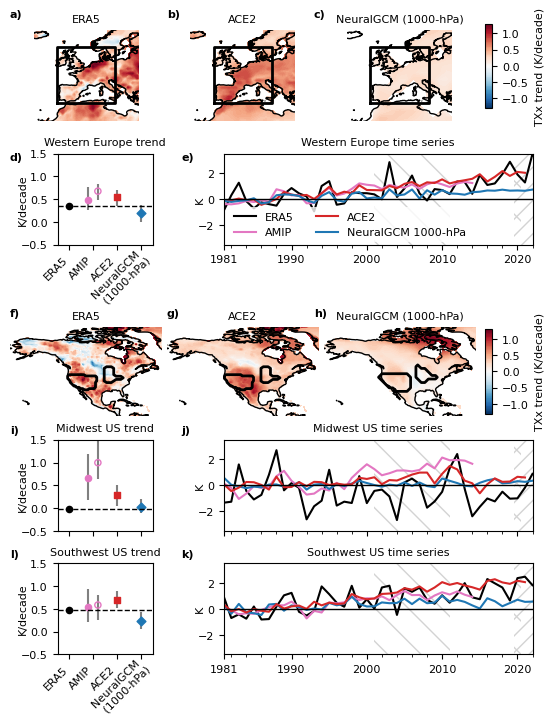

In [26]:
fig = plt.figure(figsize = (4.75,6.5))
plt.axis('off')
plt.rcParams['hatch.color'] = 'lightgray'


levels = np.arange(-1.3,1.31,step=0.025)
fontsize = 8
plt.rc('font', size=fontsize) 
height = 0.14
map_height = 0.16
vspace = 0.06
map_width = 0.32
hspace = 0.01
time_width = 0.65
spread_width = 0.2
ssize = 20
pad = -5



# a ERA5 WEU
ax = fig.add_axes([0,(3*height+map_height+4*vspace),map_width,map_height-0.02], projection=ccrs.PlateCarree())

lat = era5_regrid['latitude']
lon = era5_regrid['longitude']

datas,lons = add_cyclic_point(era5_tasmax_trend,lon)

plot = ax.contourf(lons, lat, datas, transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', levels = levels)

draw_boxes(-10,15, 36, 60)
ax.set_extent([-20,25, 28, 67], crs = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('ERA5', fontsize = fontsize)
ax.spines[:].set_visible(False)


# b ACE2 WEU
ax = fig.add_axes([map_width+hspace,(3*height+map_height+4*vspace),map_width,map_height-0.02], projection=ccrs.PlateCarree())

datas,lons = add_cyclic_point(ace2_tasmax_land.mean('member_id'),ace2_tasmax_land.longitude)

plot = ax.contourf(lons, ace2_tasmax_land.latitude, datas, transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', levels = levels)

draw_boxes(-10,15, 36, 60)
ax.set_extent([-20,25, 28, 67], crs = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('ACE2', fontsize = fontsize)
ax.spines[:].set_visible(False)


# c NGCM WEU
ax = fig.add_axes([map_width*2+hspace*2,(3*height+map_height+4*vspace),map_width,map_height-0.02], projection=ccrs.PlateCarree())

datas,lons = add_cyclic_point(ngcm_1000_trend.mean('member').T,ngcm_1000_trend.longitude)

plot = ax.contourf(lons, ngcm_1000_trend.latitude, datas, transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', levels = levels)

draw_boxes(-10,15, 36, 60)
ax.set_extent([-20,25, 28, 67], crs = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('NeuralGCM (1000-hPa)', fontsize = fontsize)
ax.spines[:].set_visible(False)

# Colorbar
cb_ax = fig.add_axes([1,(3*height+map_height+4*vspace)+0.02,0.015,0.13])
cbar = fig.colorbar(plot, ax=ax, ticks = levels, orientation = 'vertical', cax = cb_ax)
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('TXx trend (K/decade)', size=fontsize)

# d WEU Spread
ax = fig.add_axes([0.1,(height*2+map_height+vspace*3)+0.01,spread_width,height])
ax.scatter([0], get_ee(era5_tasmax_trend).values, label = 'ERA5', c = 'k', s = ssize)
amip_ee = get_ee(amip_tasmax_land).values
cesm_ee = get_ee(cesm_tasmax_trend).values
ngcm_ee = get_ee(ngcm_1000_trend).values
ace2_ee = get_ee(ace2_tasmax_land).values

ax.scatter([0.8], amip_ee.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_ee, 0.05), ymax = np.quantile(amip_ee, 0.95), zorder = -2, color = 'grey')
ax.scatter([1.2], cesm_ee.mean(), color = '#E377C2', marker = 'o', s = ssize, facecolor = 'none')
ax.vlines([1.2], ymin = np.quantile(cesm_ee, 0.05), ymax = np.quantile(cesm_ee, 0.95), zorder = -2, color = 'grey')
ax.scatter([2], ace2_ee.mean(), color = '#D62728', marker = 's', s = ssize)
ax.vlines([2], ymin = np.quantile(ace2_ee, 0.05), ymax = np.quantile(ace2_ee, 0.95), zorder = -2, color = 'grey')
ax.scatter([3], ngcm_ee.mean(), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_ee, 0.05), ymax = np.quantile(ngcm_ee, 0.95), zorder = -2, color = 'grey')

ax.set_title('Western Europe trend', fontsize = fontsize)
ax.axhline(get_ee(era5_tasmax_trend).values, color = 'k', linestyle = '--', linewidth = 1, zorder = -2)
ax.set_ylim([-0.5,1.5])
ax.set_ylabel('K/decade', fontsize = fontsize, labelpad = pad)
ax.set_yticks([-0.5,0.0,0.5,1.0,1.5])
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticklabels(['ERA5','AMIP','ACE2',''], fontsize = fontsize)
fig.text(0.30,0.535, 'NeuralGCM \n (1000-hPa)', fontsize = fontsize, rotation = 45, ha ='right')
plt.xticks(rotation = 45, ha ='right')

# e WEU time series
ax = fig.add_axes([(0.1*2+spread_width)+0.05,(height*2+map_height+vspace*3)+0.01,time_width,height])

ax.plot(era5_ee_norm.year, era5_ee_norm, color = 'k', label = "ERA5")
ax.plot(amip_ee_norm.year, amip_ee_norm.mean('member_id'), color = '#E377C2', label = 'AMIP')
ax.plot(ace2_ee_norm.year, ace2_ee_norm.TMP2m.mean('member_id'), color = '#D62728', label = "ACE2")
ax.plot(ngcm_ee_norm.year, ngcm_ee_norm.TXx1000.mean('member'), color = '#1F77B4', label = "NeuralGCM 1000-hPa")
ax.legend(bbox_to_anchor = (0,-0.03), loc = 'lower left', edgecolor = 'none', fontsize = fontsize, ncol = 2)

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.set_title('Western Europe time series', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)

# f ERA5 MWUS
ax = fig.add_axes([0,2*(height+vspace)-0.04,map_width,map_height-0.01], projection=ccrs.PlateCarree())

plot = ax.contourf(era5_tasmax_trend.longitude, era5_tasmax_trend.latitude, era5_tasmax_trend, transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', levels = levels)

ax.contour(mus_mask['lon'],mus_mask['lat'],mus_mask.fillna(0),
           levels=[0.5],
           colors='k',
           transform=ccrs.PlateCarree(),
           linewidths=2,
           )
ax.contour(mask_era5_s.longitude, mask_era5_s.latitude, np.nan_to_num(mask_era5_s), colors = 'k', linewidths = 2, levels = [0,1])

ax.set_extent([-170,-50,10,80], crs = ccrs.PlateCarree())
ax.coastlines()
ax.spines[:].set_visible(False)
ax.set_title('ERA5', fontsize = fontsize)

# g ACE2 MWUS
ax = fig.add_axes([map_width+hspace,2*(height+vspace)-0.04,map_width,map_height-0.01], projection=ccrs.PlateCarree())

datas,lons = add_cyclic_point(ace2_tasmax_land.mean('member_id'),ace2_tasmax_land.longitude)

plot = ax.contourf(lons, ace2_tasmax_land.latitude, datas, transform=ccrs.PlateCarree(),
                   cmap='RdBu_r', levels = levels)

ax.contour(mus_mask['lon'],mus_mask['lat'],mus_mask.fillna(0),
           levels=[0.5],
           colors='k',
           transform=ccrs.PlateCarree(),
           linewidths=2,
           )
ax.contour(mask_ace2_s.longitude, mask_ace2_s.latitude, np.nan_to_num(mask_ace2_s), colors = 'k', linewidths = 2, levels = [0,1])

ax.set_extent([-170,-50,10,80], crs = ccrs.PlateCarree())
ax.coastlines()
ax.spines[:].set_visible(False)
ax.set_title('ACE2', fontsize = fontsize)

# h NGCM MWUS
ax = fig.add_axes([map_width*2+hspace*2,2*(height+vspace)-0.04,map_width,map_height-0.01], projection=ccrs.PlateCarree())

ngcm_1000_land_T = ngcm_1000_trend.transpose('member','latitude','longitude')

datas,lons = add_cyclic_point(ngcm_1000_land_T.mean('member'),ngcm_1000_land_T.longitude)

plot = ax.contourf(lons,ngcm_1000_land_T.latitude, datas, transform=ccrs.PlateCarree(), levels = levels, cmap='RdBu_r')

ax.contour(mus_mask_ngcm['longitude'],mus_mask_ngcm['latitude'],mus_mask_ngcm.fillna(0),
           levels=[0.5],
           colors='k',
           transform=ccrs.PlateCarree(),
           linewidths=2,
           )
ax.contour(mask_ngcm_s.longitude, mask_ngcm_s.latitude, np.nan_to_num(mask_ngcm_s), colors = 'k', linewidths = 2, levels = [0,1])

ax.set_extent([-170,-50,10,80], crs = ccrs.PlateCarree())
ax.coastlines()
ax.spines[:].set_visible(False)
ax.set_title('NeuralGCM (1000-hPa)', fontsize = fontsize)

# Colorbar
cb_ax = fig.add_axes([1,2*(height+vspace)+0.01-0.04,0.015,0.13])
cbar = fig.colorbar(plot, ax=ax, ticks = levels, orientation = 'vertical', cax = cb_ax)
cbar.set_ticks([-1,-0.5,0,0.5,1])
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('TXx trend (K/decade)', size=fontsize)

# i MWUS Spread
ax = fig.add_axes([0.1,(height+vspace)-0.01,spread_width,height])

ax.scatter([0], area_weighted_ave(era5_tasmax_trend.where(mus_mask_1deg == 1)).values, color = 'k', s = ssize)
ngcm_mwus = area_weighted_ave(ngcm_1000_trend.where(mus_mask_ngcm == 1)).values
amip_mwus = area_weighted_ave(amip_tasmax_land.where(mus_mask_1deg == 1)).values
cesm_mwus = area_weighted_ave(cesm_tasmax_trend.where(mus_mask_cesm == 1)).values
ace2_mwus = area_weighted_ave(ace2_tasmax_land.where(mus_mask_1deg == 1)).values

ax.scatter([0.8], amip_mwus.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_mwus, 0.05), ymax = np.quantile(amip_mwus, 0.95), zorder = -2, color = 'grey')
ax.scatter([1.2], cesm_mwus.mean(), color = '#E377C2', marker = 'o', s = ssize, facecolor = 'none')
ax.vlines([1.2], ymin = np.quantile(cesm_mwus, 0.05), ymax = np.quantile(cesm_mwus, 0.95), zorder = -2, color = 'grey')
ax.scatter([2], ace2_mwus.mean(), color = '#D62728', marker = 's', s = ssize)
ax.vlines([2], ymin = np.quantile(ace2_mwus, 0.05), ymax = np.quantile(ace2_mwus, 0.95), zorder = -2, color = 'grey')
ax.scatter([3], ngcm_mwus.mean(), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_mwus, 0.05), ymax = np.quantile(ngcm_mwus, 0.95), zorder = -2, color = 'grey')

ax.set_title('Midwest US trend', fontsize = fontsize)
ax.axhline(area_weighted_ave(era5_tasmax_trend.where(mus_mask_1deg == 1)).values, linestyle='--', color='k', linewidth=1)
ax.set_ylim([-0.5,1.5])
ax.set_ylabel('K/decade', fontsize = fontsize, labelpad = pad)
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_yticks([-0.5,0.0,0.5,1.0,1.5])
ax.set_xticklabels([])
ax.tick_params(axis='both', labelsize=fontsize)
#ax.set_xticklabels(['ERA5','AMIP','ACE2',''], fontsize = fontsize)
plt.xticks(rotation = 45, ha ='right')

# j MWUS time series
ax = fig.add_axes([(0.1*2+spread_width)+0.05,(height+vspace)-0.01,time_width,height])
ax.plot(era5_mwus_norm.year, era5_mwus_norm, color = 'k')
ax.plot(amip_mwus_norm.year, amip_mwus_norm.mean('member_id'), color = '#E377C2')
ax.plot(ngcm_mwus_norm.year, ngcm_mwus_norm.TXx1000.mean('member'), color = '#1F77B4')
ax.plot(ace2_mwus_norm.year, ace2_mwus_norm.TMP2m.mean('member_id'), color = '#D62728')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.set_title('Midwest US time series', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.set_xticklabels([])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)


# k SWUS Spread
ax = fig.add_axes([0.1,0,spread_width,height])

ax.scatter([0], area_weighted_ave(era5_tasmax_trend.where(mask_era5_s == 1)).values, color = 'k', s = ssize)
ngcm_sw = area_weighted_ave(ngcm_1000_trend.where(mask_ngcm_s == 1)).values
amip_sw = area_weighted_ave(amip_tasmax_land.where(mask_amip_s == 1)).values
cesm_sw = area_weighted_ave(cesm_tasmax_trend.where(mask_cesm_s == 1)).values
ace2_sw = area_weighted_ave(ace2_tasmax_land.where(mask_ace2_s == 1)).values

ax.scatter([0.8], amip_sw.mean(), color = '#E377C2', marker = 'o', s = ssize)
ax.vlines([0.8], ymin = np.quantile(amip_sw, 0.05), ymax = np.quantile(amip_sw, 0.95), zorder = -2, color = 'grey')
ax.scatter([1.2], cesm_sw.mean(), color = '#E377C2', marker = 'o', s = ssize, facecolor = 'none')
ax.vlines([1.2], ymin = np.quantile(cesm_sw, 0.05), ymax = np.quantile(cesm_sw, 0.95), zorder = -2, color = 'grey')
ax.scatter([2], ace2_sw.mean(), color = '#D62728', marker = 's', s = ssize)
ax.vlines([2], ymin = np.quantile(ace2_sw, 0.05), ymax = np.quantile(ace2_sw, 0.95), zorder = -2, color = 'grey')
ax.scatter([3], ngcm_sw.mean(), color = '#1F77B4', marker = 'D', s = ssize)
ax.vlines([3], ymin = np.quantile(ngcm_sw, 0.05), ymax = np.quantile(ngcm_sw, 0.95), zorder = -2, color = 'grey')


ax.set_title('Southwest US trend', fontsize = fontsize)
ax.axhline(area_weighted_ave(era5_tasmax_trend.where(mask_era5_s == 1)).values, linestyle='--', color='k', linewidth=1)
ax.set_ylim([-0.5,1.5])
ax.set_ylabel('K/decade', fontsize = fontsize, labelpad = pad)
ax.set_xlim([-0.5,3.5])
ax.set_xticks([0,1,2,3])
ax.set_yticks([-0.5,0.0,0.5,1.0,1.5])
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticklabels(['ERA5','AMIP','ACE2',''], fontsize = fontsize)
fig.text(0.30,-0.095, 'NeuralGCM \n (1000-hPa)', fontsize = fontsize, rotation = 45, ha ='right')
plt.xticks(rotation = 45, ha ='right')


# l SWUS time series
ax = fig.add_axes([(0.1*2+spread_width)+0.05,0,time_width,height])

ax.plot(era5_sw_norm.year, era5_sw_norm, color = 'k')
ax.plot(amip_sw_norm.year, amip_sw_norm.mean('member_id'), color = '#E377C2')
ax.plot(ngcm_sw_norm.year, ngcm_sw_norm.TXx1000.mean('member'), color = '#1F77B4')
ax.plot(ace2_sw_norm.year, ace2_sw_norm.TMP2m.mean('member_id'), color = '#D62728')

ax.set_title('Southwest US time series', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')


fig.text(0,(3*height+2*map_height+4*vspace), 'a)', weight = 'bold')
fig.text(0.33,(3*height+2*map_height+4*vspace), 'b)', weight = 'bold')
fig.text(0.64,(3*height+2*map_height+4*vspace), 'c)', weight = 'bold')
fig.text(0,(3*height+3*vspace+map_height)+0.02-0.02, 'd)', weight = 'bold')
fig.text(0.36,(3*height+3*vspace+map_height)+0.02-0.02, 'e)', weight = 'bold')
fig.text(0,(2*height+2*vspace+map_height)+0.02-0.06, 'f)', weight = 'bold')
fig.text(0.33,(2*height+2*vspace+map_height)+0.02-0.06, 'g)', weight = 'bold')
fig.text(0.64,(2*height+2*vspace+map_height)+0.02-0.06, 'h)', weight = 'bold')
fig.text(0,((height*2+vspace)), 'i)', weight = 'bold')
fig.text(0.36,((height*2+vspace)), 'j)', weight = 'bold')
fig.text(0, 0.15, 'l)', weight = 'bold')
fig.text(0.36, 0.15, 'k)', weight = 'bold')

plt.savefig('Thermo_Fig_3_WEU.png', dpi = 600, bbox_inches='tight')
plt.savefig('Thermo_Fig_3_WEU.pdf', dpi = 600, bbox_inches='tight')
plt.savefig('Thermo_Fig_3_WEU.eps', dpi = 600, bbox_inches='tight')

In [27]:
sub_era5 = era5_tasmax_regress.year*era5_tasmax_regress.slope+era5_tasmax_regress.intercept
era5_var_time = (era5_regrid.VAR_2T.groupby('time.year').max('time').sel(year=slice('1980','2021'))-sub_era5).var('year')

sub_ace2 = (ace2_tasmax_regress.year*ace2_tasmax_regress.slope+ace2_tasmax_regress.intercept)
ace2_var_time = (ace2_tasmax.TMP2m.sel(year=slice(1980,2021))-sub_ace2).var('year')

sub_ngcm = ngcm_1000_regress.year*ngcm_1000_regress.slope+ngcm_1000_regress.intercept
ngcm_var_time = (ngcm_1000.TXx1000.sel(year=slice(1980,2021))-sub_ngcm).var('year')

In [28]:
era5_1000 = xr.open_dataset('/scratch/midway3/krucker01/ERA5/era5_t1000_6hr_annual_max_1deg_1980-2023.nc').compute()
era5_1000['latitude'] = era5_regrid['latitude']
era5_1000['longitude'] = era5_regrid['longitude']
era5_1000_land = era5_1000.where(ocean_mask==1)

era5_1000_regress = calc_trend(era5_1000_land['T'])
era5_1000_trend = era5_1000_regress.slope*10

sub_era5_1000 = era5_1000_regress.year*era5_1000_regress.slope+era5_1000_regress.intercept
era5_var_time_1000 = (era5_1000.T.groupby('time.year').max('time').sel(year=slice('1980','2021'))-sub_era5_1000).var('year')

In [32]:
# # Plot
# fig = plt.figure(figsize = (5,3))
# fontsize = 8
# plt.rc('font', size=fontsize)
# levels = np.arange(0,7.01,0.25)
# cmap_with_extremes = plt.cm.afmhot_r.with_extremes(over='black')
# norm = mcolors.BoundaryNorm(levels, cmap_with_extremes.N, extend='max')

# #ax = fig.add_axes([0,0.7,1,0.3], projection=ccrs.PlateCarree())
# ax = fig.add_axes([0,0.535,0.465,0.465], projection=ccrs.PlateCarree())

# datas, lons = add_cyclic_point(era5_var_time,era5_var_time.longitude)
# ax.coastlines()
# plot = ax.contourf(lons, era5_var_time.latitude, datas, cmap = cmap_with_extremes, 
#                    transform=ccrs.PlateCarree(), levels=levels, norm=norm, extend='max')
# ax.set_title("ERA5", fontsize = fontsize)

# # ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# #                   linewidth=1, color='gray', alpha=0.5, linestyle='--')
# ax = fig.add_axes([0.535,0.535,0.465,0.465], projection=ccrs.PlateCarree())
# datas, lons = add_cyclic_point(era5_var_time_1000,era5_var_time_1000.longitude)
# ax.coastlines()
# plot = ax.contourf(lons, era5_var_time_1000.latitude, datas, cmap = cmap_with_extremes, 
#                    transform=ccrs.PlateCarree(), levels=levels, norm=norm, extend='max')
# ax.set_title("ERA5 (1000-hPa)", fontsize = fontsize)


# ax = fig.add_axes([0,0,0.465,0.465], projection=ccrs.PlateCarree())
# #ax = fig.add_axes([0,0.35,1,0.3], projection=ccrs.PlateCarree())
# datas, lons = add_cyclic_point(ace2_var_time.sel(member_id=0),ace2_var_time.longitude)
# ax.coastlines()
# plot = ax.contourf(lons, ace2_var_time.latitude, datas, cmap = cmap_with_extremes, 
#                    transform=ccrs.PlateCarree(), levels=levels, norm=norm, extend='max')
# ax.set_title("ACE2", fontsize = fontsize)

# ax = fig.add_axes([0.535,0,0.465,0.465], projection=ccrs.PlateCarree())
# #ax = fig.add_axes([0,0,1,0.3], projection=ccrs.PlateCarree())
# datas, lons = add_cyclic_point(ngcm_var_time.sel(member=0).T,ngcm_var_time.longitude)
# ax.coastlines()
# plot = ax.contourf(lons, ngcm_var_time.latitude, datas, cmap = cmap_with_extremes, 
#                    norm=norm, transform=ccrs.PlateCarree(), levels=levels, extend='max')
# ax.set_title("NeuralGCM (1000-hPa)", fontsize = fontsize)

# cb_ax = fig.add_axes([0.3,-0.03,0.4,0.02])
# cbar = fig.colorbar(plot, ax=ax, ticks = levels, orientation = 'horizontal', 
#                     cax = cb_ax, extend = 'max')
# cbar.set_ticks([0,1,2,3,4,5,6,7])
# cbar.minorticks_off()
# cbar.ax.tick_params(labelsize=fontsize)
# cbar.set_label(r'Variance K$^2$', fontsize = fontsize)

# fig.text(0,0.99, 'a)', weight = 'bold', fontsize = fontsize)
# fig.text(0.55,0.99, 'b)', weight = 'bold', fontsize = fontsize)
# fig.text(0,0.47, 'c)', weight = 'bold', fontsize = fontsize)
# fig.text(0.55,0.47, 'd)', weight = 'bold', fontsize = fontsize)

# plt.savefig('Thermo_fig_var_time.eps', dpi = 450, bbox_inches='tight')
# plt.savefig('Thermo_fig_var_time.png', dpi = 450, bbox_inches='tight');

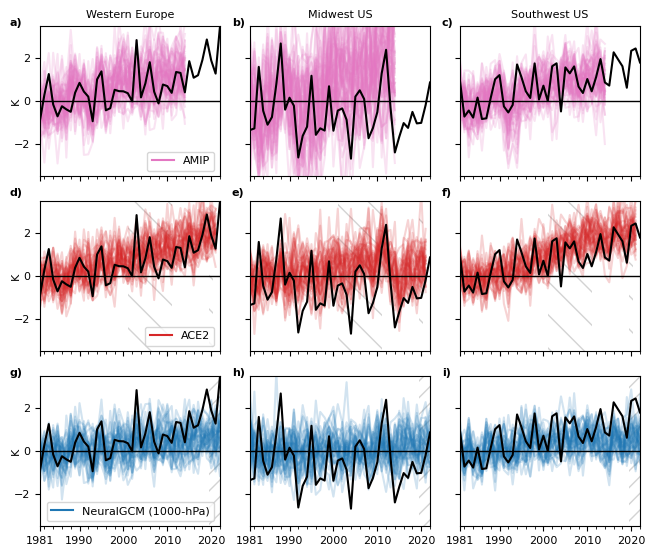

In [31]:
# Ensemble spread Western Europe
fig = plt.figure(figsize = (6,5))
fontsize = 8
plt.rc('font', size=fontsize)

ax = fig.add_axes([0,0.7,0.3,0.3])
ax.set_rasterized(True)
ax.plot(amip_ee_norm.year, amip_ee_norm, color = '#E377C2', alpha = 0.2)
ax.plot(era5_ee_norm.year, era5_ee_norm, color = 'k')
plt.plot([],[], color = '#E377C2', label = 'AMIP')
ax.set_title('Western Europe', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticklabels([])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(loc = 'lower right')

ax = fig.add_axes([0,0.35,0.3,0.3])
ax.set_rasterized(True)
ax.plot(ace2_ee_norm.year, ace2_ee_norm.TMP2m, color = '#D62728', alpha = 0.2)
ax.plot(era5_ee_norm.year, era5_ee_norm, color = 'k')
plt.plot([],[], color = '#D62728', label = 'ACE2')
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
#ax.set_title('ACE2 vs ERA5', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.set_xticklabels([])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(loc = 'lower right')

ax = fig.add_axes([0,0,0.3,0.3])
ax.set_rasterized(True)
ax.plot(ngcm_ee_norm.year, ngcm_ee_norm.TXx1000.T, color = '#1F77B4', alpha = 0.2)
ax.plot(era5_ee_norm.year, era5_ee_norm, color = 'k')
plt.plot([],[], color = '#1F77B4', label = 'NeuralGCM (1000-hPa)')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

#ax.set_title('NeuralGCM vs ERA5', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(loc = 'lower right')

fig.text(-0.05, 1, 'a)', weight = 'bold')
fig.text(-0.05,0.66, 'd)', weight = 'bold')
fig.text(-0.05,0.3, 'g)', weight = 'bold')

ax = fig.add_axes([0.35,0.7,0.3,0.3])
ax.set_rasterized(True)
ax.plot(amip_mwus_norm.year, amip_mwus_norm, color = '#E377C2', alpha = 0.2)
ax.plot(era5_mwus_norm.year, era5_mwus_norm, color = 'k')
ax.set_title('Midwest US', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticklabels([])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
#ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.set_yticklabels([])
ax.tick_params(axis='both', labelsize=fontsize)


ax = fig.add_axes([0.35,0.35,0.3,0.3])
ax.set_rasterized(True)
ax.plot(ace2_mwus_norm.year, ace2_mwus_norm.TMP2m, color = '#D62728', alpha = 0.2)
ax.plot(era5_mwus_norm.year, era5_mwus_norm, color = 'k')
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
#ax.set_title('ACE2 vs ERA5', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.set_xticklabels([])
ax.xaxis.set_minor_locator(MultipleLocator(2))
#ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.set_yticklabels([])
ax.tick_params(axis='both', labelsize=fontsize)


ax = fig.add_axes([0.35,0,0.3,0.3])
ax.set_rasterized(True)
ax.plot(ngcm_mwus_norm.year, ngcm_mwus_norm.TXx1000.T, color = '#1F77B4', alpha = 0.2)
ax.plot(era5_mwus_norm.year, era5_mwus_norm, color = 'k')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

#ax.set_title('NeuralGCM vs ERA5', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
#ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.set_yticklabels([])
ax.tick_params(axis='both', labelsize=fontsize)

fig.text(0.32, 1, 'b)', weight = 'bold')
fig.text(0.32,0.66, 'e)', weight = 'bold')
fig.text(0.32,0.3, 'h)', weight = 'bold')

ax = fig.add_axes([0.7,0.7,0.3,0.3])
ax.set_rasterized(True)
ax.plot(amip_sw_norm.year, amip_sw_norm, color = '#E377C2', alpha = 0.2)
ax.plot(era5_sw_norm.year, era5_sw_norm, color = 'k')
ax.set_title('Southwest US', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticklabels([])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_yticklabels([])
#ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)

ax = fig.add_axes([0.7,0.35,0.3,0.3])
ax.set_rasterized(True)
ax.plot(ace2_sw_norm.year, ace2_sw_norm.TMP2m, color = '#D62728', alpha = 0.2, label = 'ACE2')
ax.plot(era5_sw_norm.year, era5_sw_norm, color = 'k')
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
#ax.set_title('ACE2 vs ERA5', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981, 2022])
ax.set_ylim([-3.5,3.5])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.set_xticklabels([])
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.set_yticklabels([])
#ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)

ax = fig.add_axes([0.7,0,0.3,0.3])
ax.set_rasterized(True)
ax.plot(ngcm_sw_norm.year, ngcm_sw_norm.TXx1000.T, color = '#1F77B4', alpha = 0.2, label = "NeuralGCM (1000-hPa)")
ax.plot(era5_sw_norm.year, era5_sw_norm, color = 'k')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

#ax.set_title('NeuralGCM vs ERA5', fontsize = fontsize)
ax.axhline(0,color = 'k', linewidth = 1)
ax.set_xlim([1981,2022])
ax.set_ylim([-3.5,3.5])
ax.set_yticklabels([])
#ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_xticks([1981,1990,2000,2010,2020])
ax.xaxis.set_minor_locator(MultipleLocator(2))
#ax.set_ylabel('K', fontsize = fontsize, labelpad = pad)
ax.tick_params(axis='both', labelsize=fontsize)

fig.text(0.67, 1, 'c)', weight = 'bold')
fig.text(0.67,0.66, 'f)', weight = 'bold')
fig.text(0.67,0.3, 'i)', weight = 'bold')


plt.savefig('Thermo_fig_ensemble_time_series.eps', dpi = 450, bbox_inches='tight')
plt.savefig('Thermo_fig_ensemble_time_series.png', dpi = 450, bbox_inches='tight')